## Emotional Analysis 

#### Emotion Detection
- Dataset (train, test, val)
- EDA
- Text preprocessing (cleaning and tokenization)
- Text vectorization (tfidf)
- Data resampling (if imbalance)
- Model (RandomForestClassifier, SVM, LogisticRegression, MultinomialNB)
- VotingClassifier and evaluation
- Prediction

### Dataset

In [1]:
# import opendatasets as od
# dataset_url = 'https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp'
# od.download(dataset_url)

In [2]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer

### EDA

In [3]:
# read and create dataframes
traindf = pd.read_csv('emotions-dataset-for-nlp/train.txt', sep=';', header=None, names=['Text', 'Emotion'])
test_df = pd.read_csv('emotions-dataset-for-nlp/test.txt', sep=';', header=None, names=['Text', 'Emotion'])
val_df = pd.read_csv('emotions-dataset-for-nlp/val.txt', sep=';', header=None, names=['Text', 'Emotion'])

In [4]:
train_df = pd.concat([traindf, val_df])

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     18000 non-null  object
 1   Emotion  18000 non-null  object
dtypes: object(2)
memory usage: 421.9+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2000 non-null   object
 1   Emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


- Count the emotion values

In [7]:
train_df['Emotion'].value_counts()

Emotion
joy         6066
sadness     5216
anger       2434
fear        2149
love        1482
surprise     653
Name: count, dtype: int64

In [8]:
import seaborn as sns

<Axes: xlabel='count', ylabel='Emotion'>

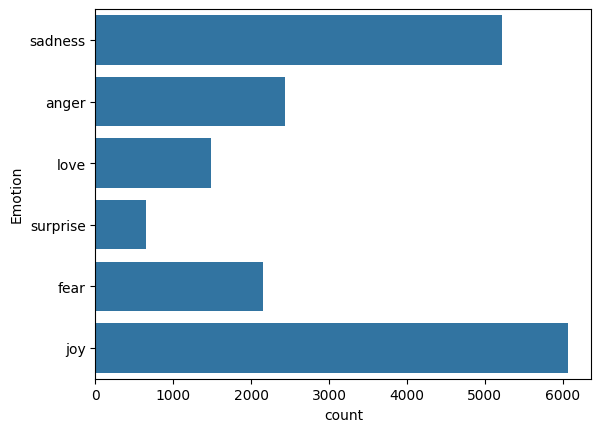

In [9]:
sns.countplot(train_df['Emotion'])

<br>
Looks like our data is imbalance -- surprise and love seems to be in minority whereas joy and sadness is in majority
<br>
Therefore, we will apply SMOTENC to oversample the minority class

In [10]:
# !pip install imbalanced-learn -q

In [11]:
# convert the Emotion data as Categorial
train_df_em_ct = train_df['Emotion'].astype("category")
train_df_em_ct.dtypes

CategoricalDtype(categories=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], ordered=False, categories_dtype=object)

In [12]:
train_df.columns

Index(['Text', 'Emotion'], dtype='object')

### Preprocessing

- Preprocessing
    - remove non alphabets
    - convert to lower case
    - split words (use it as token)
    - (skip) stemming on tokens (for faster processing and to get essential meaning of words without much grametical correctness)
    - join words

In [13]:
def preprocess_text(text):
    processed_text = re.sub('[^a-zA-Z]', ' ', text) # remove non-alphabet
    processed_text = text.lower()
    processed_text = processed_text.split() 

    # steming data
    # ps = PorterStemmer()
    # processed_text = [ps.stem(word) for word in processed_text if word not in set(stopwords.words('english'))]
    processed_text = ' '.join(processed_text)
    return processed_text

In [14]:
# train_df['Text'].apply(preprocess_text) # can directly apply in tfidf

#### Vectorization of text data

In [15]:
from time import time

en_stopwords = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words=en_stopwords, preprocessor=preprocess_text) 
t0 = time()
train_vec = tfidf.fit_transform(train_df['Text'])

print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 0.245 s


In [16]:
train_vec.shape

(18000, 16029)

In [17]:
train_df_em_ct.shape

(18000,)

#### Oversampling

- Oversampling
    - SMOTNEC (for categorial data with dataframe)
    - input (X, y)
         - X: data to be resampled (csr_matrix -- shape:(n_samples, n_features))
         - y: categorial features corresponds to the data (X) (shape(n_samples, ))
    - sampling_strategy
        - minority: resample only the minority class
        - not majority: resample all classes but the majority class

##### Sampling strategy: minority 

In [18]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(sampling_strategy='minority', random_state=42, categorical_features=[0,1,2,3,4,5])

X = train_vec          # data to resample
y = train_df_em_ct     # categorial features corresponds to the data (X)
t0 = time()
# smotenc
X_res_min, y_res_min = sm.fit_resample(X, y) # pass categorial data as smotenc accept it as categorial format

print(f"resampling done in {time() - t0:.3f} s")

resampling done in 1.618 s


In [19]:
X_res_min.shape

(23413, 16029)

In [20]:
y_res_min.shape

(23413,)

<Axes: xlabel='count'>

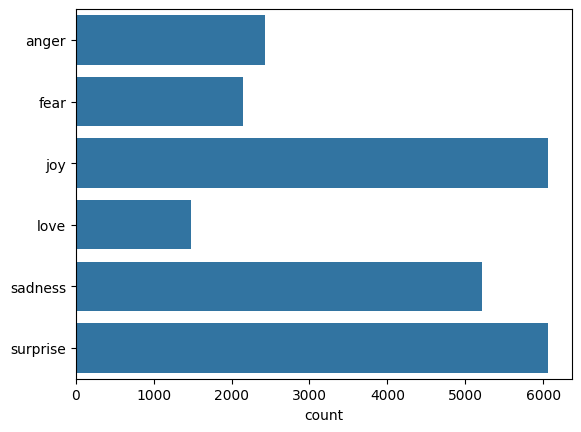

In [21]:
sns.countplot(y_res_min.values)

##### Sampling strategy: not majority 

In [22]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(sampling_strategy='not majority', random_state=42, categorical_features=[0,1,2,3,4,5])

X = train_vec          # data to resample
y = train_df_em_ct     # categorial features corresponds to the data (X)
t0 = time()
# smotenc
X_res, y_res = sm.fit_resample(X, y) # pass categorial data as smotenc accept it as categorial format

print(f"resampling with all minority class done in {time() - t0:.3f} s")

resampling with all minority class done in 4.900 s


In [23]:
X_res.shape

(36396, 16029)

In [24]:
y_res.shape

(36396,)

<Axes: xlabel='count'>

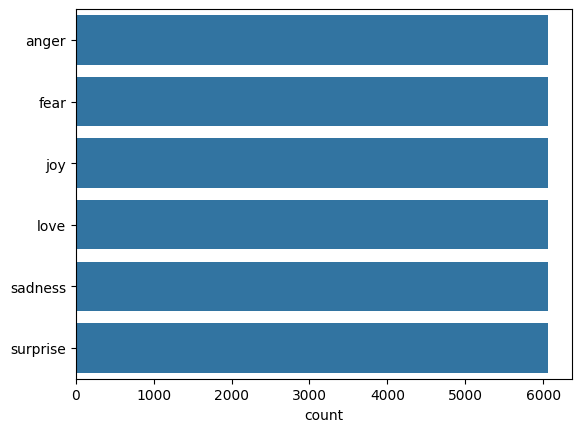

In [25]:
sns.countplot(y_res.values)

**let's go with not majority sampling**

In [26]:
type(X_res)

scipy.sparse._csr.csr_matrix

- Revert back to text data

In [27]:
train_df_res = tfidf.inverse_transform(X_res)

In [28]:
len(train_df_res)

36396

In [29]:
type(train_df_res)

list

In [30]:
train_df_res[:12]

[array(['didnt', 'feel', 'humiliated'], dtype='<U74'),
 array(['around', 'awake', 'cares', 'damned', 'feeling', 'go', 'hopeful',
        'hopeless', 'someone'], dtype='<U74'),
 array(['feel', 'grabbing', 'greedy', 'im', 'minute', 'post', 'wrong'],
       dtype='<U74'),
 array(['ever', 'feeling', 'fireplace', 'know', 'nostalgic', 'property',
        'still'], dtype='<U74'),
 array(['feeling', 'grouchy'], dtype='<U74'),
 array(['burdened', 'feeling', 'ive', 'lately', 'little', 'sure', 'wasnt'],
       dtype='<U74'),
 array(['also', 'amount', 'asleep', 'fallen', 'faster', 'feel', 'funny',
        'ive', 'like', 'lot', 'milligrams', 'recommended', 'taking',
        'times'], dtype='<U74'),
 array(['confused', 'feel', 'jaded', 'life', 'man', 'old', 'teenager',
        'year'], dtype='<U74'),
 array(['feel', 'huge', 'made', 'performed', 'petronas', 'profit', 'well',
        'years'], dtype='<U74'),
 array(['feel', 'romantic'], dtype='<U74'),
 array(['feel', 'like', 'make', 'mean', 'seeing', 

In [31]:
# join str arr and create a dataframe
train_df_res_ = pd.DataFrame(train_df_res).apply(lambda x: ' '.join(item for item in x if item), axis=1) # join as col
train_df_res_[:12]

0                                 didnt feel humiliated
1     around awake cares damned feeling go hopeful h...
2             feel grabbing greedy im minute post wrong
3     ever feeling fireplace know nostalgic property...
4                                       feeling grouchy
5         burdened feeling ive lately little sure wasnt
6     also amount asleep fallen faster feel funny iv...
7        confused feel jaded life man old teenager year
8     feel huge made performed petronas profit well ...
9                                         feel romantic
10       feel like make mean seeing something suffering
11    divine encounter expect experience feel runnin...
dtype: object

In [32]:
len(train_df_res_)

36396

In [33]:
len(y_res)

36396

In [34]:
y_res.values

['sadness', 'sadness', 'anger', 'love', 'anger', ..., 'surprise', 'surprise', 'surprise', 'surprise', 'surprise']
Length: 36396
Categories (6, object): ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [35]:
type(train_df_res_)

pandas.core.series.Series

In [36]:
train_df_res_.shape

(36396,)

In [37]:
y_res.shape

(36396,)

In [38]:
train_df_res_.values

array(['didnt feel humiliated',
       'around awake cares damned feeling go hopeful hopeless someone',
       'feel grabbing greedy im minute post wrong', ...,
       'check contractions could didnt downstairs dull feel feeling hour kind nurse said sensation still strange want',
       'bi creativity feeling finance got im impressed little manufacturing steve us used',
       'bungalow delighted feeling florida guests guy im like little making much new overwhelmed pic preparing starved thanksgiving time weekend work'],
      dtype=object)

### Model

- On resampled data

#### RandomForestClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

t0 = time()
vectorizer = CountVectorizer()
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=1)

pipeline = Pipeline([
    ("vectorizer", vectorizer),   
    ("classifier", rf)            
])

pipeline.fit(train_df_res_.values, y_res.values)
print(f"RF -- time taken: {time() - t0:.3f} s")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s


RF -- time taken: 2.030 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished


In [40]:
train_pred = pipeline.predict(train_df_res_.values)
train_accuracy = accuracy_score(y_res.values, train_pred)
print("Train set accuracy on resampled data:", train_accuracy)

Train set accuracy on resampled data: 0.9986536982085944


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


In [42]:
# test acc
x_test_procceced = test_df['Text'].apply(preprocess_text)
test_pred = pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.866


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### SVM

In [48]:
from sklearn.svm import SVC

t0 = time()
vectorizer = CountVectorizer()
svm = SVC(kernel="linear",gamma=1, C=.5, random_state=42)
svm_pipeline = Pipeline(
                [   ("vectorizer", vectorizer),
                    ("svm", svm),
                ]
)
svm_pipeline.fit(train_df_res_.values, y_res.values) 
print(f"SVM -- time taken: {time() - t0:.3f} s")

SVM -- time taken: 27.785 s


In [49]:
# train acc
train_pred = svm_pipeline.predict(train_df_res_.values)
train_accuracy = accuracy_score(y_res.values, train_pred)
print("SVM -- Train accuracy:", train_accuracy)

# test acc
test_pred = svm_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("SVM -- Test accuracy:", test_accuracy)

SVM -- Train accuracy: 0.9908231673810309
SVM -- Test accuracy: 0.8795


#### LogisticRegression

In [50]:
from sklearn.linear_model import LogisticRegression

t0 = time()
vectorizer = CountVectorizer()
logistics = LogisticRegression(random_state=42, max_iter=1000)

logs_pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),   
    ("classifier", logistics)  
])

logs_pipeline.fit(train_df_res_.values, y_res.values)
print(f"LogisticRegression -- time taken: {time() - t0:.3f} s")

LogisticRegression -- time taken: 1.869 s


In [51]:
# train acc
train_pred = logs_pipeline.predict(train_df_res_.values)
train_accuracy = accuracy_score(y_res.values, train_pred)
print("LR -- Train accuracy:", train_accuracy)

# test acc
test_pred = logs_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("LR -- Test accuracy:", test_accuracy)

LR -- Train accuracy: 0.9900538520716562
LR -- Test accuracy: 0.8845


#### MultinomialNB

In [52]:
from sklearn.naive_bayes import MultinomialNB

t0 = time()
vectorizer = CountVectorizer()
mnb = MultinomialNB()

mnb_pipeline = Pipeline(
    [  ("vectorizer", CountVectorizer()), 
       ("classifier", mnb) 
    ])

mnb_pipeline.fit(train_df_res_.values, y_res.values)
print(f"MNB -- time taken: {time() - t0:.3f} s")

MNB -- time taken: 0.297 s


In [54]:
# train acc
train_pred = mnb_pipeline.predict(train_df_res_.values)
train_accuracy = accuracy_score(y_res.values, train_pred)
print("MNB -- Train accuracy:", train_accuracy)

# test acc
test_pred = mnb_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("MNB -- Test accuracy:", test_accuracy)

MNB -- Train accuracy: 0.9568908671282559
MNB -- Test accuracy: 0.8075


#### Voting Classifier

Voting Classifier work as estimator that combine predictions from multiple models and learns from these individual models to make a final prediction.

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)


In [55]:
from sklearn.ensemble import VotingClassifier

estimators=[
        ("RFC", pipeline),
        ("Logistics Regression", logs_pipeline),
        ("SVM", svm_pipeline),
        ("MNB", mnb_pipeline),
]

voting_classifier = VotingClassifier(estimators, voting='hard')
voting_classifier.fit(train_df_res_.values, y_res.values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished


VotingClassifier(estimators=[('RFC',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               RandomForestClassifier(n_estimators=50,
                                                                      n_jobs=-1,
                                                                      random_state=42,
                                                                      verbose=1))])),
                             ('Logistics Regression',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))])),
                             ('SVM',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('svm',
                                               SVC(C=0.5, gamma=1,
                                                   kernel='linear',
                                                   random_state=42))])),
                             ('MNB',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               MultinomialNB())]))])

In [56]:
# train acc
train_pred = voting_classifier.predict(train_df_res_.values)
train_accuracy = accuracy_score(y_res.values, train_pred)
print("VC -- Train accuracy:", train_accuracy)

# test acc
test_pred = voting_classifier.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("VC -- Test accuracy:", test_accuracy)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


VC -- Train accuracy: 0.9919496647983295


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


VC -- Test accuracy: 0.8845


#### Prediction

In [57]:
sample_text = "I'm feeling happy and excited today"
predicted_emotion = voting_classifier.predict([sample_text])
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: ['joy']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [58]:
sample_text = "feeling scared and the rage filled im mad at me"
predicted_emotion = voting_classifier.predict([sample_text])
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: ['fear']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [59]:
sample_text = "they were gentle reminders that while god hasnt always promised an easy road he has promised to be with us"
predicted_emotion = voting_classifier.predict([sample_text])
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: ['love']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [60]:
sample_text = "my room is messy if theyre open"
predicted_emotion = voting_classifier.predict([sample_text])
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: ['sadness']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
